<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
ticker = "QQQ"
look_back = 5 #  number of past days we want to use to predict 1 day in the future.
max_data_size = 730 # ~2 years
split_percent = 0.90 # use 90% of the data  for train
print_level = 'DEBUG'
nr_of_features = 4

In [21]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T'
print(url)
stock_api_response = pd.read_json(url)
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);

data = []
lstm_data = []
split_coefficient = 1

for key, value in stock_api_data.items():
  date = key
  open = float(value.get('1. open'))
  high = float(value.get('2. high'))
  low = float(value.get('3. low'))
  close = float(value.get('4. close'))
  adjusted_close = float(value.get('5. adjusted close'))
  volume = int(value.get('6. volume'))
  divident = float(value.get('7. dividend amount'))

  if float(value.get('8. split coefficient')) > 1:
    split_coefficient = float(value.get('8. split coefficient'))
    
  open = open / split_coefficient
  high = high /split_coefficient
  close = close / split_coefficient
  low = low / split_coefficient
  
  # 3 features
  lstm_data.append([
    close,
    high,
    low
  ])

  data.append([
      date,
      close,
      volume,
      high,
      low,
      open,
      divident
      ])

last_data =  str(data[0][0])

if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
  lstm_data = np.flip(lstm_data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
  lstm_data = np.flip(lstm_data,axis=0)

print(np.expand_dims(data[:,2], axis=1))
print(np.append(lstm_data, np.expand_dims(data[:,2], axis=1), axis=1))

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=QQQ&outputsize=full&apikey=3F4URDEKOPLFH25T
[['71715526']
 ['80432176']
 ['73960758']
 ['59058296']
 ['53779992']
 ['46377864']
 ['56547419']
 ['74834076']
 ['63642120']
 ['81856456']
 ['99002139']
 ['141129408']
 ['56163290']
 ['98982064']
 ['85824343']
 ['77856625']
 ['53015313']
 ['58576672']
 ['74820225']
 ['74709320']
 ['52059331']
 ['49388694']
 ['46491747']
 ['38943414']
 ['30176643']
 ['30710234']
 ['40874224']
 ['33812190']
 ['39328959']
 ['57183243']
 ['56711694']
 ['38106062']
 ['32413351']
 ['36466069']
 ['33491216']
 ['30784175']
 ['41346533']
 ['37258361']
 ['32143672']
 ['26718781']
 ['28156368']
 ['27970006']
 ['42036193']
 ['29020747']
 ['21434088']
 ['29722073']
 ['26094136']
 ['30326830']
 ['32521685']
 ['19487679']
 ['32592995']
 ['25207401']
 ['27735358']
 ['32608754']
 ['21939717']
 ['25162014']
 ['25085470']
 ['31431156']
 ['38063458']
 ['22319863']
 ['27194581']
 ['39407443']
 ['3930322

In [22]:
if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('data ===>', 'size:',len(data), 'max_data_size:', max_data_size, 'shape:', data.shape)
  print(data[:look_back])
  print('lstm_data ===>', 'size:',len(lstm_data), 'max_data_size:', max_data_size, 'shape:', lstm_data.shape)
  print(lstm_data[:look_back])

data ===> size: 730 max_data_size: 730 shape: (730, 7)
[['2018-12-06' '166.89' '71715526' '166.91' '161.77' '162.46' '0.0']
 ['2018-12-07' '161.38' '80432176' '167.12' '160.86' '166.16' '0.0']
 ['2018-12-10' '163.07' '73960758' '163.78' '159.41' '161.08' '0.0']
 ['2018-12-11' '163.61' '59058296' '165.77' '162.23' '165.73' '0.0']
 ['2018-12-12' '165.05' '53779992' '167.6' '164.96' '166.0' '0.0']]
lstm_data ===> size: 730 max_data_size: 730 shape: (730, 3)
[[ 166.89  166.91  161.77]
 [ 161.38  167.12  160.86]
 [ 163.07  163.78  159.41]
 [ 163.61  165.77  162.23]
 [ 165.05  167.60  164.96]]


In [23]:
df = pd.DataFrame(data,columns=['Date','Close','Volume','High','Low','Open','Divident'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
#df.head()

df_train = df.iloc[:split]
df_test = df.iloc[split:]

lstm_train_data = lstm_data[:split]
lstm_test_data = lstm_data[split:]

In [24]:
if print_level == 'DEBUG':
  print('df_test ===>', 'size:',len(df_test),'shape:', df_test.shape)
  print(df_test.head())

  print('df_train ===>', 'size:',len(df_train),'shape:', df_train.shape)
  print(df_train.head())

  print('lstm_test_data ===>', 'size:',len(lstm_test_data), 'shape:', lstm_test_data.shape)
  print(lstm_test_data[:2*(look_back + 1)])

  print('lstm_train_data ===>', 'size:',len(lstm_train_data), 'shape:', lstm_train_data.shape)
  print(lstm_train_data[:2*(look_back + 1)])

df_test ===> size: 73 shape: (73, 10)
           Date   Close    Volume  ...      50MA     100MA      200MA
657  2021-07-19  354.67  64404625  ...  341.9156  333.5636  318.96170
658  2021-07-20  358.79  42183702  ...  342.4074  334.0232  319.34440
659  2021-07-21  361.56  30259860  ...  343.1234  334.4974  319.78065
660  2021-07-22  363.95  30252240  ...  343.8962  334.9010  320.19960
661  2021-07-23   368.2  31960799  ...  344.9224  335.3990  320.66480

[5 rows x 10 columns]
df_train ===> size: 657 shape: (657, 10)
         Date   Close    Volume    High  ... Divident 50MA 100MA  200MA
0  2018-12-06  166.89  71715526  166.91  ...      0.0  NaN   NaN    NaN
1  2018-12-07  161.38  80432176  167.12  ...      0.0  NaN   NaN    NaN
2  2018-12-10  163.07  73960758  163.78  ...      0.0  NaN   NaN    NaN
3  2018-12-11  163.61  59058296  165.77  ...      0.0  NaN   NaN    NaN
4  2018-12-12  165.05  53779992   167.6  ...      0.0  NaN   NaN    NaN

[5 rows x 10 columns]
lstm_test_data ===> siz

In [182]:
np.set_printoptions(formatter={'float': '{: 0.12f}'.format})

mean_data = np.mean(lstm_data)
max_data = np.amax(lstm_data)

#print('mean:', mean_data, 'max:', max_data, 'min:',0)
scaler_data = [[mean_data], [max_data*1.5], [0]]

scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = scaler.fit(lstm_data)
scaler = scaler.fit(scaler_data)

lstm_train_data_scaled = scaler.transform(lstm_train_data)
if print_level == 'DEBUG':
  print(lstm_train_data_scaled[:look_back+1])

lstm_test_data_scaled = scaler.transform(lstm_test_data)
if print_level == 'DEBUG':
  print(lstm_test_data_scaled[:look_back+1])

[[ 0.288346600548  0.299116968985  0.287998608030  0.122832211927]
 [ 0.290382356779  0.290417156031  0.281473748314  0.124782332420]
 [ 0.280795162904  0.290782548175  0.279890382357  0.139948977337]
 [ 0.283735699682  0.284971073122  0.277367436600  0.128688952108]
 [ 0.284675279481  0.288433598678  0.282274131106  0.102759225717]
 [ 0.287180825612  0.291617730219  0.287024228979  0.093575174214]]
[[ 0.622210622472  0.630579842533  0.621584235939  0.082234044108]
 [ 0.617112532081  0.617999913002  0.612536430467  0.112061638175]
 [ 0.624281177955  0.626873722215  0.615598764627  0.073398063422]
 [ 0.629100874331  0.629100874331  0.623115403019  0.052651024403]
 [ 0.633259384923  0.633276784549  0.629466266475  0.052637765888]
 [ 0.640654225934  0.641150115273  0.633199704206  0.055610594632]]


In [183]:
train_generator = TimeseriesGenerator(lstm_train_data_scaled, lstm_train_data_scaled, length=look_back, batch_size=1)

if print_level == 'DEBUG':
  print('Samples: %d' % len(train_generator))
  # print each sample
  for i in range(2):
    x, y = train_generator[i]
    print('%s => %s' % (x, y))

Samples: 652
[[[ 0.288346600548  0.299116968985  0.287998608030  0.122832211927]
  [ 0.290382356779  0.290417156031  0.281473748314  0.124782332420]
  [ 0.280795162904  0.290782548175  0.279890382357  0.139948977337]
  [ 0.283735699682  0.284971073122  0.277367436600  0.128688952108]
  [ 0.284675279481  0.288433598678  0.282274131106  0.102759225717]]] => [[ 0.287180825612  0.291617730219  0.287024228979  0.093575174214]]
[[[ 0.290382356779  0.290417156031  0.281473748314  0.124782332420]
  [ 0.280795162904  0.290782548175  0.279890382357  0.139948977337]
  [ 0.283735699682  0.284971073122  0.277367436600  0.128688952108]
  [ 0.284675279481  0.288433598678  0.282274131106  0.102759225717]
  [ 0.287180825612  0.291617730219  0.287024228979  0.093575174214]]] => [[ 0.287267823742  0.290260559398  0.285406063770  0.080695748401]]


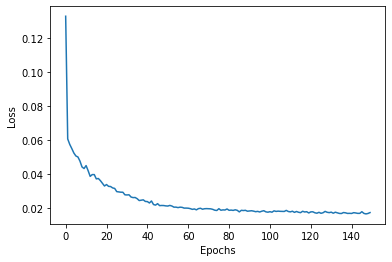

In [184]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(look_back, nr_of_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(nr_of_features))

model.compile(
    loss=MAE,
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mae"]
)
  
#model.summary()

modelo = model.fit(train_generator, epochs=150, verbose=0)
if print_level == 'DEBUG':
  plt.plot(modelo.history['loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [185]:
test_generator = TimeseriesGenerator(lstm_test_data_scaled, lstm_test_data_scaled, length=look_back, batch_size=1)

print('Samples: %d' % len(test_generator))
# print each sample
for i in range(2):
	x, y = test_generator[i]
	print('%s => %s' % (x, y))

Samples: 68
[[[ 0.622210622472  0.630579842533  0.621584235939  0.082234044108]
  [ 0.617112532081  0.617999913002  0.612536430467  0.112061638175]
  [ 0.624281177955  0.626873722215  0.615598764627  0.073398063422]
  [ 0.629100874331  0.629100874331  0.623115403019  0.052651024403]
  [ 0.633259384923  0.633276784549  0.629466266475  0.052637765888]]] => [[ 0.640654225934  0.641150115273  0.633199704206  0.055610594632]]
[[[ 0.617112532081  0.617999913002  0.612536430467  0.112061638175]
  [ 0.624281177955  0.626873722215  0.615598764627  0.073398063422]
  [ 0.629100874331  0.629100874331  0.623115403019  0.052651024403]
  [ 0.633259384923  0.633276784549  0.629466266475  0.052637765888]
  [ 0.640654225934  0.641150115273  0.633199704206  0.055610594632]]] => [[ 0.641158815085  0.641854800122  0.637872025751  0.049481275393]]


In [186]:
#Make prediction
prediction_scaled = model.predict(test_generator)

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.12f}'.format})
  print(prediction_scaled[:5])

prediction = scaler.inverse_transform(prediction_scaled)

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('prediction shape:',prediction.shape)

  for x in range(look_back + 1):
    print('pred:',prediction[x], 'test:', lstm_test_data[x])


[[ 0.599249839783  0.598545372486  0.592907130718  0.060396239161]
 [ 0.599635243416  0.598857641220  0.593316674232  0.060202833265]
 [ 0.603618979454  0.602370142937  0.597201585770  0.059577167034]
 [ 0.606364130974  0.604773879051  0.599845886230  0.059204846621]
 [ 0.608019828796  0.606209278107  0.601420044899  0.059014465660]]
prediction shape: (68, 4)
pred: [ 344.40  344.00  340.76  34.71] test: [ 357.60  362.41  357.24  47.26]
pred: [ 344.63  344.18  340.99  34.60] test: [ 354.67  355.18  352.04  64.40]
pred: [ 346.91  346.20  343.23  34.24] test: [ 358.79  360.28  353.80  42.18]
pred: [ 348.49  347.58  344.75  34.03] test: [ 361.56  361.56  358.12  30.26]
pred: [ 349.44  348.40  345.65  33.92] test: [ 363.95  363.96  361.77  30.25]
pred: [ 350.13  348.98  346.31  33.79] test: [ 368.20  368.49  363.92  31.96]


In [187]:
def predict(num_prediction, model):
    prediction_list = df_for_test_scaled[-look_back:]
    print(prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, len(features)))
        out = model.predict(x)
        print(x,out) 
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = look_back
forecast_scaled = predict(num_prediction, model)
print(forecast_scaled)
forecast_dates = predict_dates(num_prediction)

forecast = test_scaler.inverse_transform(forecast_scaled.reshape((-1,1)))
forecast_prices = forecast.reshape((-1))
forecast_dates,forecast

NameError: ignored

In [ ]:
scaler_data = [[*1.5], [0]]
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = scaler.fit(lstm_data)
scaler = scaler.fit(scaler_data)